### A Deep Learning Kalman Filter
###### A Kalman Filter can be integrated with a deep learning model to create a hybrid system that can learn from data and provide more accurate predictions. In this example,  a simple LSTM (Long Short-Term Memory) model from the Keras library will assist in this manner. 

In [14]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')
# Copy Lake Winnipeg's error recordings. 
!cp '/content/drive/MyDrive/Kalman_Filter/winnipeg.csv' '/content/'

Mounted at /content/drive


In [11]:
# Install pykalman if not already installed. 
!pip install pykalman

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48461 sha256=91c979af3e9f2e3ef7e83462b9a7b6b6e61fd2c593132afbe5218dc0840659f5
  Stored in directory: /root/.cache/pip/wheels/7a/68/21/675239322d2bb2e8e1fa317d4bd7b5566a4e82780b25a27f7a
Successfully built pykalman


In [37]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from pykalman import KalmanFilter

# Load or generate your dataset
# Assuming your dataset is a time series data with one feature
data = pd.read_csv("winnipeg.csv")
data = data.drop('Unnamed: 0', axis=1)
data = data.values.reshape(-1, 1)

# Preprocess the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Train-test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Create input and output sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length - 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 5
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

# Reshape the input for LSTM model
X_train = X_train.reshape(X_train.shape[0], seq_length, 1)
X_test = X_test.reshape(X_test.shape[0], seq_length, 1)

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

# Predict with the LSTM model
lstm_predictions = model.predict(X_test)

# Create the Kalman Filter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
kf = kf.em(train)

# Integrate the Kalman Filter with LSTM predictions
filtered_state_means, _ = kf.filter(lstm_predictions)

# Inverse transform predictions to original scale
lstm_predictions = scaler.inverse_transform(lstm_predictions)
filtered_state_means = scaler.inverse_transform(filtered_state_means)

# Evaluate the model
mse = np.mean((y_test - lstm_predictions) ** 2)
filtered_mse = np.mean((y_test - filtered_state_means) ** 2)

print("MSE for LSTM predictions:", mse)
print("MSE for Kalman-filtered LSTM predictions:", filtered_mse)


4/4 [==============================] - 1s 4ms/step
MSE for LSTM predictions: 88.12495260334448
MSE for Kalman-filtered LSTM predictions: 80.34929132786002


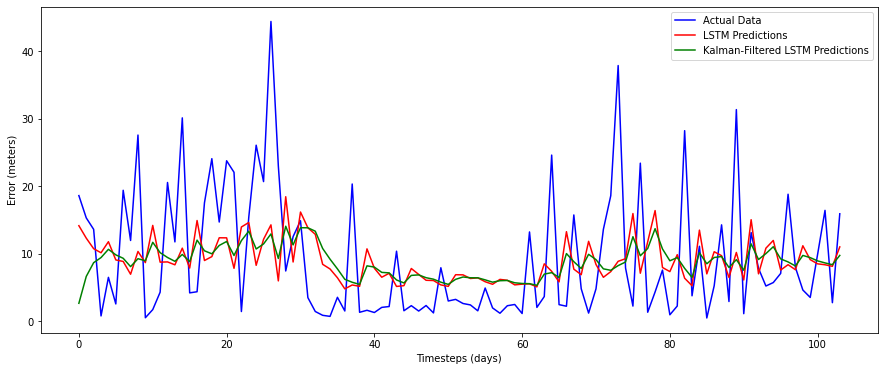

In [41]:
import matplotlib.pyplot as plt

# Prepare the actual data for plotting
y_test_inv = scaler.inverse_transform(y_test)

# Calculate the index range for the x-axis
x_range = range(104)

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(x_range, y_test_inv, label="Actual Data", color="blue")
plt.plot(x_range, lstm_predictions, label="LSTM Predictions", color="red")
plt.plot(x_range, filtered_state_means, label="Kalman-Filtered LSTM Predictions", color="green")
plt.xlabel("Timesteps (days)")
plt.ylabel("Error (meters)")
plt.legend()
plt.show()
